<a href="https://colab.research.google.com/github/Melsonwang1/CVNL-assignment/blob/main/RNN%20emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/My\ Drive/Colab\ Notebooks/
!ls
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from idlmam  import *

Mounted at /content/drive
drive  sample_data


/content/drive/My Drive/Colab Notebooks/idlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import unicodedata
import string
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

print("importing the relevant modules")

importing the relevant modules


In [4]:
!pip install datasets
print("download dataset to import it later on")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syste

In [5]:

from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions")

# Check the dataset structure
print(dataset)
label_mapping = dataset["train"].features["labels"].feature.names
print(label_mapping)  # List of all emotion labels


print("importing the go_emotions dataset and printint the dataset out to check format of dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
importing the go_emotions dataset and printint the dataset out to check format of dataset


In [6]:
import string
import unicodedata
from datasets import load_dataset


# Initialize the emotion_data dictionary
emotion_data = {}

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {all_letters[i]: i for i in range(n_letters)}

# Define function to normalize text
def unicodeToAscii(s):
    """Turns a Unicode string into plain ASCII."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

# Building the emotion_data dictionary
print("\nBuilding emotion_data from dataset...\n")
for sample in dataset["train"]:  # Loop through the training data
    text = sample["text"]  # The text sample
    labels = sample["labels"]  # The list of labels for this sample

    # Normalize the text using the unicodeToAscii function
    normalized_text = unicodeToAscii(text).lower()

    # Loop through all labels for this sample (in case there are multiple labels)
    for label in labels:
        emotion = label_mapping[label]  # Map label index to emotion name

        # Add to the emotion_data dictionary
        if emotion not in emotion_data:
            emotion_data[emotion] = []  # Initialize the list for this emotion
        emotion_data[emotion].append(normalized_text)

# Print out the emotion names and their respective text count before removing
print("\nEmotion counts before removing samples:")
for emotion, texts in emotion_data.items():
    print(f"{emotion}: {len(texts)} samples")

# Remove 12,000 "neutral" samples
if "neutral" in emotion_data:
    num_samples_to_remove = 12000
    if len(emotion_data["neutral"]) >= num_samples_to_remove:
        emotion_data["neutral"] = emotion_data["neutral"][:-num_samples_to_remove]  # Remove 12,000 samples
        print(f"\nRemoved 12,000 neutral samples. Remaining neutral samples: {len(emotion_data['neutral'])}")
    else:
        print(f"\nNot enough neutral samples to remove. Only {len(emotion_data['neutral'])} available.")
else:
    print("\nNo 'neutral' samples found in the dataset.")

# Print out the updated emotion names and their respective text count after removal
print("\nEmotion counts after removing samples:")
for emotion, texts in emotion_data.items():
    print(f"{emotion}: {len(texts)} samples")



Building emotion_data from dataset...


Emotion counts before removing samples:
neutral: 14219 samples
anger: 1567 samples
fear: 596 samples
annoyance: 2470 samples
surprise: 1060 samples
gratitude: 2662 samples
desire: 641 samples
optimism: 1581 samples
admiration: 4130 samples
confusion: 1368 samples
amusement: 2328 samples
approval: 2939 samples
caring: 1087 samples
embarrassment: 303 samples
realization: 1110 samples
disappointment: 1269 samples
grief: 77 samples
sadness: 1326 samples
curiosity: 2191 samples
joy: 1452 samples
love: 2086 samples
excitement: 853 samples
disapproval: 2022 samples
remorse: 545 samples
disgust: 793 samples
relief: 153 samples
pride: 111 samples
nervousness: 164 samples

Removed 12,000 neutral samples. Remaining neutral samples: 2219

Emotion counts after removing samples:
neutral: 2219 samples
anger: 1567 samples
fear: 596 samples
annoyance: 2470 samples
surprise: 1060 samples
gratitude: 2662 samples
desire: 641 samples
optimism: 1581 samples
admiratio

In [7]:
class EmotionTextDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
              if len(sample) > 0:
                self.data.append(sample)
                self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long
        values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """

        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Convert the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label


In [8]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming you have a dataset class or data already loaded as `LanguageNameDataset`
# Make sure `emotion_data` and `alphabet` are appropriately defined

dataset = EmotionTextDataset(emotion_data, alphabet)

# Calculate the sizes for the splits (80% train, 20% test)
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

# Split the dataset into training and testing sets
train_data, test_data = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# Print the size of each split to verify
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")



Training data size: 31282
Testing data size: 7821


In [9]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)

    print(input_sequence.shape, x_seq.shape)
    print(x_seq)



torch.Size([5]) torch.Size([5, 2])
tensor([[ 0.6195, -0.8119],
        [ 0.8334, -1.8488],
        [ 0.8334, -1.8488],
        [ 0.6195, -0.8119],
        [ 0.5678,  0.6776]])


In [10]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple,
            last_step = last_step[0]#then h_t is the first item in the tuple

        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1]
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)

        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)


In [11]:
def pad_and_pack(batch):
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)

    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)

    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched


In [12]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects.
    This wrapper class will fix that. If a normal input comes in, it will
    use the regular Embedding layer. Otherwise, it will work on the packed
    sequence to return a new Packed sequence of the appropriate result.
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer

    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input,
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(),
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)



In [14]:
# for 16 batch size
D = 64
B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_packed = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_packed.to(device)

loss_func = nn.CrossEntropyLoss()
device = "cuda"

packed_train = train_simple_network(rnn_packed, loss_func, \
                                    train_loader, \
                                    test_loader=test_loader, \
                                    score_funcs={'Accuracy': \
                                                 accuracy_score}, \
                                    device=device, epochs=10)




Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

In [16]:
# for 3 layers

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_3layer.to(device)
rnn_3layer_results = train_simple_network(
    rnn_3layer,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=20,
    lr=0.01
)



Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

In [4]:
import seaborn as sns


In [5]:
sns.lineplot(x='epoch', y='test Accuracy', data=packed_train,label='RNN:Packed Input')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_results, label='rnn_3layer_results')

print("This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD")
print("Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.")
print("It also seemed like the model could be even more accurate based on the graph if given more epochs")



NameError: name 'packed_train' is not defined

In [20]:
#For biderectional batch size = 16 number of layers =3

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, \
                                          loss_func, train_loader, \
                                            test_loader=test_loader, \
                                            score_funcs={'Accuracy': \
                                          accuracy_score}, \
                                             device=device,\
                                              epochs=20, \
                                                lr=0.01)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD
Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.
It also seemed like the model could be even more accurate based on the graph if given more epochs


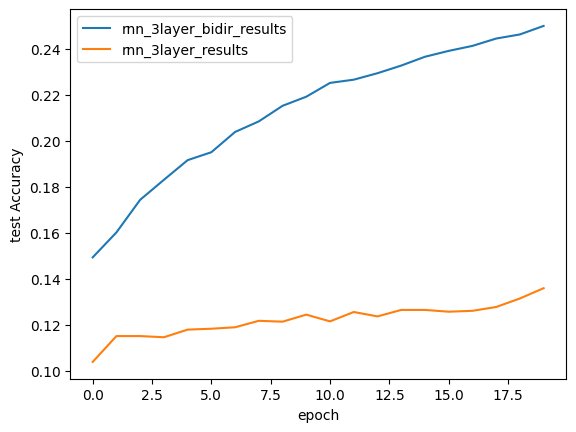

In [25]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_results,label='rnn_3layer_bidir_results')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_results, label='rnn_3layer_results')

print("This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD")
print("Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.")
print("It also seemed like the model could be even more accurate based on the graph if given more epochs")



In [22]:
#try using adam to see if model acc improves
def train_simple_network_Adamw(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cpu", checkpoint_file=None, lr=0.001):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #Using Adam
    optimizer =  torch.optim.AdamW(model.parameters(), lr=0.001)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [23]:
#For biderectional batch size = 16 number of layers =3

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_AdamW = train_simple_network(rnn_3layer_bidir, \
                                          loss_func, train_loader, \
                                            test_loader=test_loader, \
                                            score_funcs={'Accuracy': \
                                          accuracy_score}, \
                                             device=device,\
                                              epochs=20, \
                                                lr=0.01)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD
Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.
It also seemed like the model could be even more accurate based on the graph if given more epochs


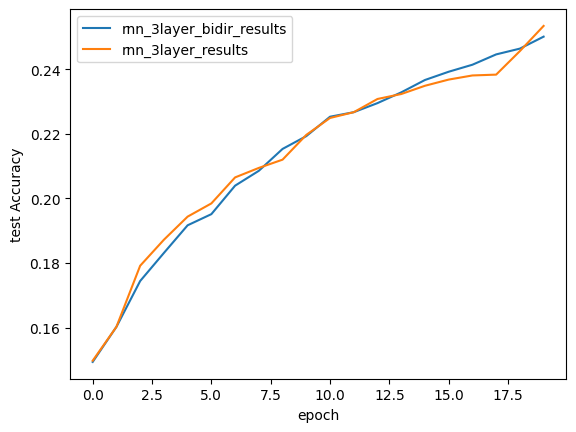

In [26]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_results,label='rnn_3layer_bidir_results')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_AdamW, label='rnn_3layer_results')

print("This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD")
print("Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.")
print("It also seemed like the model could be even more accurate based on the graph if given more epochs")



In [27]:
#For biderectional batch size = 16 number of layers =3 epoch= 40

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_AdamW_40epoch = train_simple_network(rnn_3layer_bidir, \
                                          loss_func, train_loader, \
                                            test_loader=test_loader, \
                                            score_funcs={'Accuracy': \
                                          accuracy_score}, \
                                             device=device,\
                                              epochs=40, \
                                                lr=0.01)


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

In [3]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_results,label='rnn_3layer_bidir_results')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_AdamW, label='rnn_3layer_results')

print("This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD")
print("Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.")
print("It also seemed like the model could be even more accurate based on the graph if given more epochs")



NameError: name 'sns' is not defined